In [40]:
## Import packages all packages required should be installed with pyxem
import hyperSLIC
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import pyxem as pxm
import scipy.ndimage as nd
import copy
from numba import jit
import time
from scipy.stats import pearsonr
from tqdm import tqdm
import os
%matplotlib qt6

In [2]:
## Load the data lazily
s = hs.load(r"C:\Users\tas72\Documents\GitHub\hyperSLIC\data\20230309_181055_data.zspy",lazy=True)
s.rechunk(nav_chunks = 'auto',sig_chunks=-1)
## Load the data into RAM
s.compute()
## Apply a mask to the direct beam - SLIC will still work without this however I've found inclucing only signal from  
mask = np.zeros((515,515)) # Shape of detector
mask[515//2,515//2]=1
x = np.arange(0, 60)
y = np.arange(0, 60)
arr = np.zeros((y.size, x.size))
cx = 30.
cy = 30.
r = 14.
circle = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
mask = nd.grey_dilation(mask,mode = 'constant',footprint=circle).astype('bool')
mask = ~ mask
s.data = s.data*mask

[########################################] | 100% Completed | 45.40 s


In [4]:
s.plot(vmax=4) # inspect the data

In [3]:
raveled = np.reshape(s.data, (s.axes_manager[1].size, s.axes_manager[0].size,s.axes_manager[2].size*s.axes_manager[3].size)) #unravel the last dimesion of the data to give an numpy array of shape (256,256,515*515)

After unraveling the signal axis we only wish to retain pixels on the detector which will help the most during the clustering. These pixels are where there is a large change in the variance (or dynamic range which can also be used as a proxy for variance), nominally this corresponds to areas on the detector where a Bragg reflection appears.

In [4]:
## Define functions which will help us discard detector pixels which have a low dynamic range or variance

def plot_ranges(raveled,percentile,bins, mode, plot_or_not):
    '''
    Print the thershold value determined by the inputted percentile of dynamic range or variance, and plot a histogram showing the threshold.
    
    Parameters
    ----------
    raveled: numpy array
    The unraveled SED data, in the form of a numpy array, with the last dimenion being the unraveled signal from the detector.
    
    percentile: int between 0-100
    The percentile at wish you wish to discard below.
    
    bins: int
    Defines how many bins in the histogram. Only relevent if plot_or_not == True.
    
    mode: {'range', 'var'}
    Wether to use the dynamic range ('range') or variance ('var') as a metric to define which pixels are to be kept.
    
    plot_or_not: True/False
    Wether to plot the hitogram or not.
    '''
    reshaped = np.reshape(raveled, (np.shape(raveled)[0]*np.shape(raveled)[1], np.shape(raveled)[2]))
    if mode == 'range':
        ranges = np.ptp(reshaped, axis=0)
    if mode == 'var':
        ranges = np.var(reshaped,axis=0)
    percentile = np.percentile(ranges,percentile)
    print(f'Cut off point: {percentile}')
    if plot_or_not == True:
        fig,ax = plt.subplots()
        ax.hist(ranges,density = True, bins = bins)
        plt.yscale('log')

        ax.axvline(percentile,linestyle = ":",color ='r' )

@jit(nopython = True)
def quick_wheat(ranges, reshaped, percentile):
    wheat = reshaped.T[ranges >= percentile]
    return wheat.T

def wheat_from_chaff(data, percentile,mode):
    '''
    Seperates the useful data with high dynamic range or variance (wheat) and discards the rest (chaff)
    
    Parameters
    ----------
    data: numpy array
    The unraveled SED data, in the form of a numpy array, with the last dimenion being the unraveled signal from the detector.

    percentile: int between 0-100
    The percentile at wish you wish to discard below.
 
    mode: {'range', 'var'}
    Wether to use the dynamic range ('range') or variance ('var') as a metric to define which detector pixels are to be kept.
    
    '''
    reshaped = np.reshape(data, (np.shape(data)[0]*np.shape(data)[1], np.shape(data)[2]))
    print(np.shape(reshaped))
    print('Reshaped')
    if mode == 'range':
        ranges = np.ptp(reshaped, axis=0)
    if mode == 'var':
        ranges = np.var(reshaped,axis=0)
    ranges = np.ptp(reshaped, axis=0)
    print(np.shape(ranges))
    print('Ranges aquried')
    percentile = np.percentile(ranges,percentile)
    print(percentile)
    wheat = quick_wheat(ranges, reshaped, percentile)
    print(np.shape(wheat))
    print('Wheat separated')
    maxes = np.amax(wheat, axis=0)
    minis = np.amin(wheat,axis=0) 
    
    wheat = wheat - minis

    wheat = wheat/maxes
    
    wheat = np.reshape(wheat,(np.shape(data)[0],np.shape(data)[1],-1))
    print('Complete, ', np.shape(wheat))
    return wheat

In [9]:
plot_ranges(raveled,98,50,'range',True) # Inspect where the threshold for discarding detector pixels with low dynamic range or variance is

Cut off point: 32.0


In [10]:
wheat = wheat_from_chaff(raveled,98,'range') # Discard data which has a dynamic range lower than the 95th percentile and normalise the data

(65025, 265225)
Reshaped
(265225,)
Ranges aquried
32.0
(65025, 5377)
Wheat separated
Complete,  (255, 255, 5377)


In [11]:
wheat_hs = hs.signals.Signal1D(wheat) # create a hyperspy object from the good data

In [12]:
wheat_hs.T.plot() # Inspect the channels which were retained

In [24]:
## Define hyperparameters for the SLIC clustering
iterations = 10
cluster_number = 200
m_value = 1.1
searchspace = 1.5
method = 'regular' # 'random' 'semi'
test = hyperSLIC.SLIC(wheat_hs,method,cluster_number,m_value,searchspace)

In [25]:
## Run the clustering loop alternating between find_closest_centeroid() and update_centeroids()
t0 = time.time()
for i in tqdm(range(iterations)):
    test.find_closest_centeroid()
    test.update_centeroids()
print(f'Computer time: {int(time.time()-t0)}s')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:26<00:00,  8.64s/it]

Computer time: 86s


In [29]:
## PLot where each centroid has ended up
centeroids = np.zeros((test.width,test.height))
for counter,centeroid in enumerate(test.xy_centeroids):
    centeroids[int(centeroid[0]),int(centeroid[1])] = counter    
fig,ax = plt.subplots()
ax.imshow(centeroids,vmax=1)
plt.tight_layout()

In [33]:
## Define a colour map for visualisation
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.gist_stern(vals))

In [71]:
## Visualise the clusters and overlay this onto the data
fig,ax = plt.subplots(1,3)
ax[0].imshow(test.image,cmap='gray')
ax[1].imshow(test.closest_centeroid,cmap=cmap)
ax[2].imshow(test.image,cmap='gray')
ax[2].imshow(test.closest_centeroid,cmap=cmap,alpha=0.25)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
plt.tight_layout()

At this stage we may want to alter the hyperparamerts and rerun the SLIC clustering to potentially imporve the performance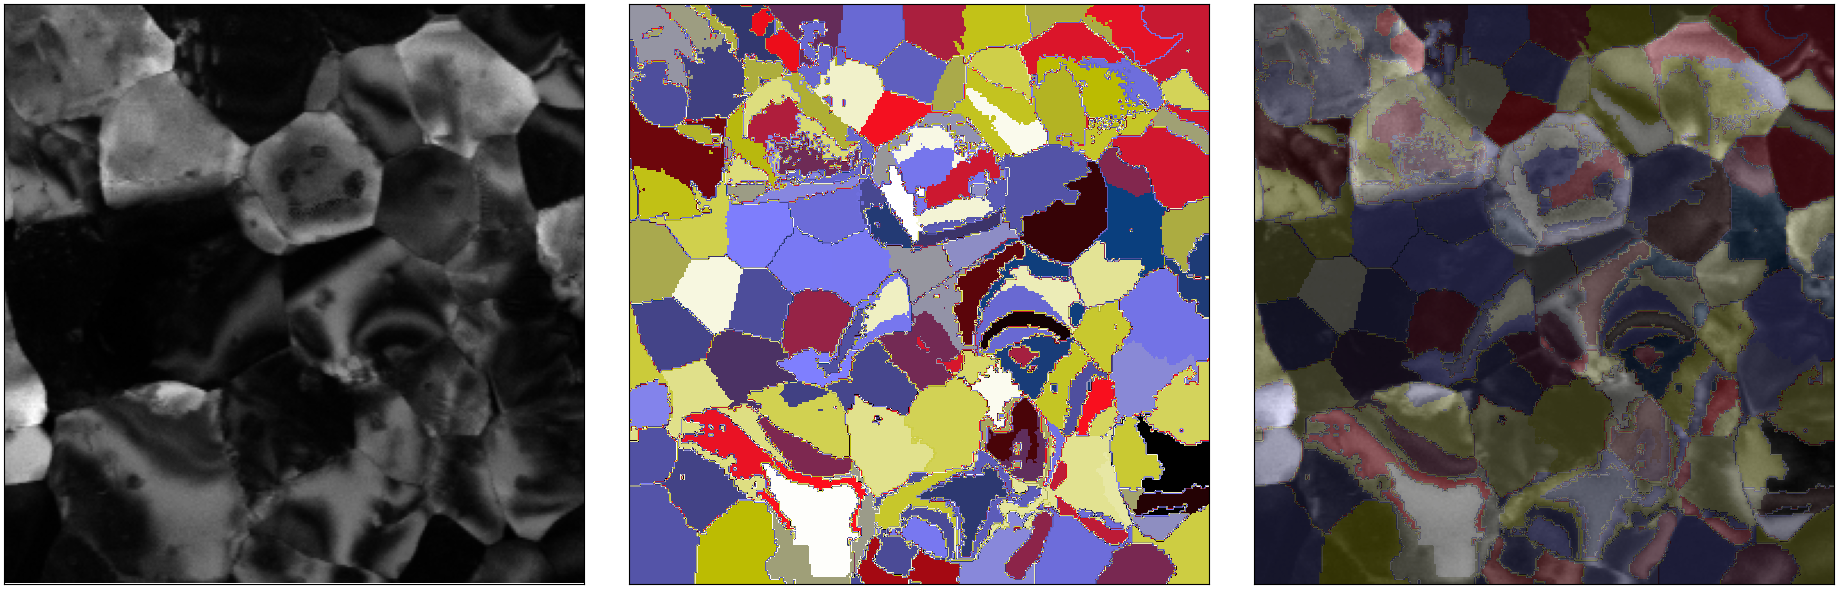

Calculate the mean value for the channels within each cluster

In [58]:
summed_channels = np.zeros(test.k,dtype='object')
number_of_occurances = np.zeros(test.k)

for row in tqdm(range(np.shape(test.closest_centeroid)[0])):
    for col in range(np.shape(test.closest_centeroid)[1]):
        
        arg = int(test.closest_centeroid[row,col])
        number_of_occurances[arg] += 1 
        channel = test.dot_data[row,col].astype(np.float32)# Use the copy not the data with the masked bright feild
        summed_channels[arg]+=channel

for i in range(len(number_of_occurances)):
    occurances = number_of_occurances[i]
    if occurances == 0:
        number_of_occurances[i] = np.nan
        

mean_channels = summed_channels/number_of_occurances

100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [00:05<00:00, 43.09it/s]


We now check if the clustered regions from SLIC are similar to eachother (using Pearson's correlation coefficient) and combine them if this is the case.

In [73]:
combine_threshold = 0.93 # Alter this to change how many clusters are combined 
updated_centroids = copy.deepcopy(test.closest_centeroid)
for i in tqdm(range(len(mean_channels))):
    channel_oi = mean_channels[i]
    for counter,comparison_channel in enumerate(mean_channels[i:]):
        difference = channel_oi - comparison_channel
        difference = np.abs(difference)
        difference = np.sum(difference)
        try:
            r = pearsonr(channel_oi,comparison_channel)
            if r[0] > combine_threshold:
                args = np.where(updated_centroids == i)
                for j in range(len(args[0])):
                        row = args[0][j]
                        col = args[1][j]
                        updated_centroids[row,col] = i+counter
        except:
            pass
                
fig,ax = plt.subplots(1,3)
ax[0].imshow(test.image,cmap='gray')
ax[1].imshow(test.closest_centeroid,cmap=cmap)
ax[1].set_title('SLIC clusters')
ax[2].imshow(test.image,cmap='gray')
ax[2].imshow(updated_centroids,cmap=cmap,alpha=0.5)
ax[2].set_title('Combined clusters')
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 31.35it/s]


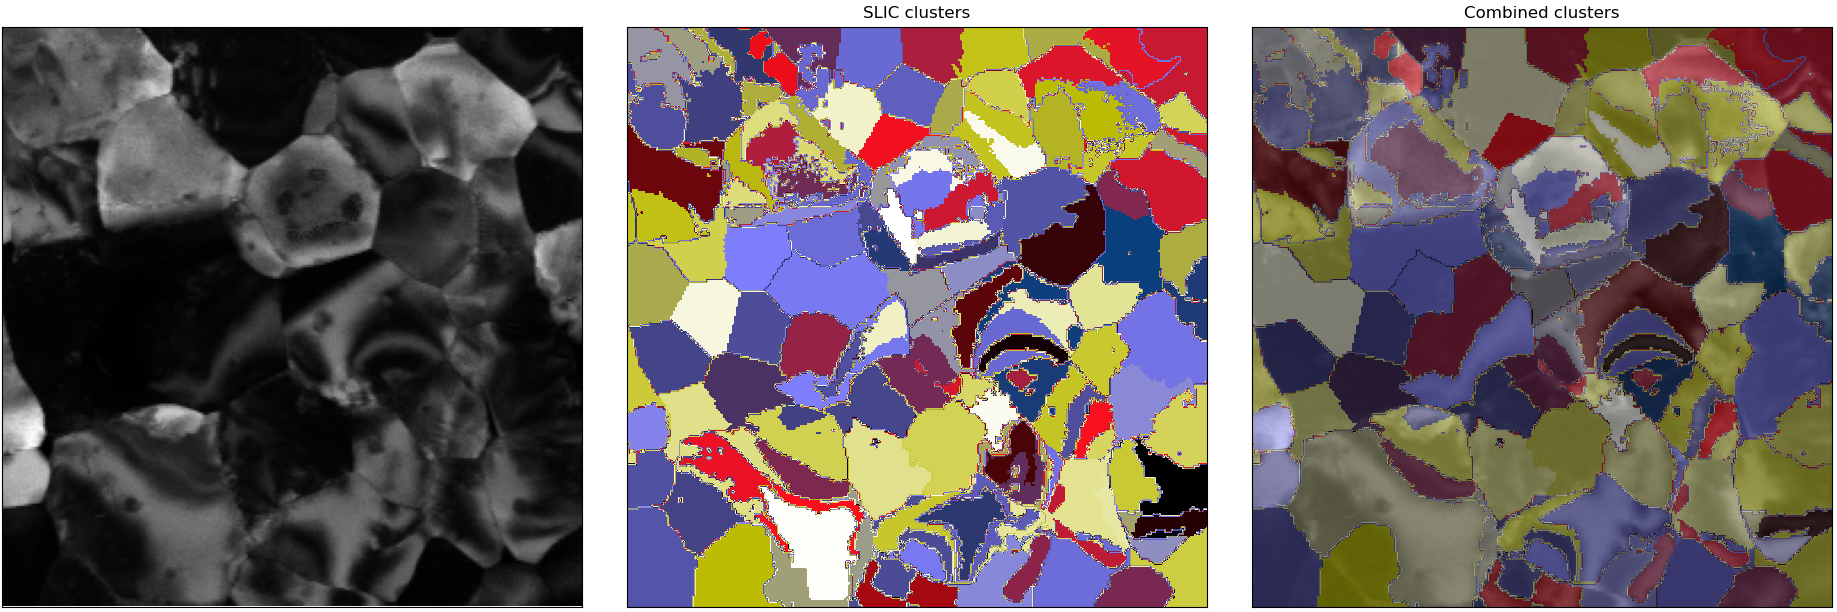

In [45]:
s = hs.load(r"C:\Users\tas72\Documents\GitHub\hyperSLIC\data\20230309_181055_data.zspy",lazy=True) # Reload the data without the direct beam masked
s.compute()

[########################################] | 100% Completed | 46.67 s


In [83]:
## Now we need to calculate the mean patterns from each cluster from the original data
summed_patterns = np.zeros(test.k,dtype='object')
number_of_occurances = np.zeros(test.k)

for row in tqdm(range(np.shape(updated_centroids)[0])):
    for col in range(np.shape(updated_centroids)[1]):
        
        arg = int(updated_centroids[row,col])
        number_of_occurances[arg] += 1 
        pattern = s.data[row,col].astype(np.float32)
        summed_patterns[arg]+=pattern

for i in range(len(number_of_occurances)):
    occurances = number_of_occurances[i]
    if occurances == 0:
        number_of_occurances[i] = -1
        

mean_patterns = summed_patterns/number_of_occurances

100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [00:21<00:00, 11.71it/s]


In [74]:
## Plot all the mean patterns in a grid
grid_x, grid_y = 10,20
fig,ax = plt.subplots(grid_x,grid_y)
for i in range(grid_x):
    for j in range(grid_y):
        try:
            ax[i,j].imshow(mean_patterns[i*grid_x+j],vmax=0.1,cmap='Greys')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
        except:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

plt.tight_layout()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0,wspace=-0, hspace=0)

In [95]:
## Plot the mean pattens one by one (advance by clicking the plot)
for i,pattern in enumerate(mean_patterns):
    print(i,end=' ')
    try:
        fig,ax = plt.subplots()
        ax.imshow(pattern,vmax=0.05)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.waitforbuttonpress()
        plt.close()
    except:
        plt.close()                                                       

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [79]:
## Plot a pattern from a certain cluster and show where it is located
num = 89 # cluster number
image = np.zeros((test.height,test.width))
image[updated_centroids==num]=1
fig,ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(mean_patterns[num],vmax=0.05)
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()

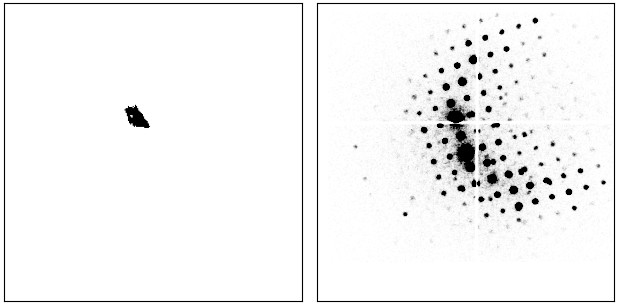

In [94]:
## Save results as a numpy array
#Reduce size a little
for i,pattern in enumerate(mean_patterns):
    try:
        mean_patterns[i] = pattern.astype('float16')
    except: pass
#Save mean patterns and clusters        
np.save('cluster_patterns.npy',mean_patterns)
np.save('clusters.npy',updated_centroids)